### Library Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mmd_mom import MMD_MOM
import time

from sklearn.metrics.pairwise import pairwise_kernels

In [2]:
# ITE module to compute analytic values of mmd
from ite.cost.x_analytical_values import analytical_value_d_mmd
from ite.cost.x_kernel import Kernel

### Definition of parameters

In [3]:
def kernel(x,y=None): 
    return pairwise_kernels(x,y,'polynomial',degree=2)
num_of_samples= np.arange(200,2001,400)

#Number of Monte-Carlo simulation
M=10
# Remark that some of the variables are changed compared to the article for shorter time of computation. 
# For example num_of_samples and M, the number of Monte-Carlo simulations.

# Definition of the solvers we will work with. Change "BCD_Fast" to "BCD" to use BCD algorithm.
solvers=[{"MON":True,'solver':'BCD','Q':11,'beta':0.05,'nb_shuffle':1,'kernel':kernel},
        {"MON":True,'solver':'BCD_Fast','Q':11,'beta':0.05,'nb_shuffle':5,'kernel':kernel},
        {"MON":False,'kernel':kernel}]

# Number of outliers
Nc=3
# For normal law: choose mean and covariances
dim=1

m1 = np.random.rand()
m2 = np.random.rand()

c2 = np.random.rand()**2
c1 = np.random.rand()**2

### Basic use of MMD computation

In [4]:
# Computation of MMD using BCD algorithm with 5 blocks and polynomial kernel 
# between two gaussian sample of size 100
test=MMD_MOM(Q=5,kernel=kernel)
test.estimate(np.random.normal(size=[100,1]),np.random.normal(size=[100,1]))

0.17879675539097414

### Some useful functions

In [5]:
def ustat(x,y,ker):
    
    n = len(x)    
    ky1y1 = ker(x)
    ky2y2 = ker(y)
    ky1y2 = ker(x,y)

    # make the diagonal zero in ky1y1 and ky2y2:
    ky1y1 = ky1y1-np.diag(np.diag(ky1y1))
    ky2y2 = ky2y2-np.diag(np.diag(ky2y2))

    term1 = np.sum(ky1y1) / (n * (n-1))
    term2 = np.sum(ky2y2) / (n * (n-1))
    term3 = -2 * np.sum(ky1y2) / (n**2)

    # absolute(): to avoid 'sqrt(negative)' values:
    d = np.sqrt(np.absolute(term1 + term2 + term3))
    return d


# Function to simulate dataset
def make_dataset(law,N):
    if law == 'without_outliers':
        y1 = np.random.normal(m1, c1, N)
        y2 = np.random.normal(m2, c2,N)
    elif law == 'with_outliers':
        y1 = np.hstack([2000*np.ones([Nc]),np.random.normal(m1, c1, N-Nc)])
        y2 = np.hstack([4000*np.ones([Nc]),np.random.normal(m2, c2,N-Nc)])
    elif law == 'pareto':
        y1 = np.random.pareto(3, size=[N])
        y2 = np.random.pareto(3, size=[N])
    return y1.reshape(-1,1),y2.reshape(-1,1)

# Plot function
def errorbar(x,y,err,legend):
    plt.plot(x,y,label=legend)
    plt.xlabel('$\ln($time in s$)$')
    plt.ylabel('$\ln(|\widehat{MMD}-MMD|)$')
    plt.fill_between(x, err[0], err[1],alpha=0.25)
def log_error(x,axis=0):
    return np.vstack([np.log(np.percentile(x,25,axis=axis)),np.log(np.percentile(x,75,axis=axis))])
    

### Function to compute the mmd's in several context

In [6]:
def compute_mmds(law,solvers,num_of_samples,M=30):
    mmds=np.zeros([len(solvers),M,len(num_of_samples)])
    for m in range(M):
        print('\r step '+str(m)+' over '+str(M),end='')
        for n,N in enumerate(num_of_samples):
            y1,y2=make_dataset(law,N)
            for i,sol in enumerate(solvers):
                if sol.get('MON'):
                    params={k:solvers[0][k] for k in list(solvers[0].keys())[1:] if k in solvers[0]}
                    mmd=MMD_MOM(**params)
                    # Regularization of the matrix depending on the case
                    if law == 'without outliers':
                        mmd.epsilon=1e-3
                    else:
                        mmd.epsilon=1
                            
                    mmds[i,m,n]=mmd.estimate(y1,y2)
                else:
                    mmds[i,m,n]=ustat(y1,y2,sol.get('kernel'))
    print('\r Computation finished')

    return mmds
                

# Polynomial Kernel of degree 2

### Computation of analytical MMD -- Gaussian case

In [7]:
par1 = {"mean": m1, "cov": c1}
par2 = {"mean": m2, "cov": c2}
d = analytical_value_d_mmd('normal', 'normal', Kernel({'name': 'polynomial', 'exponent': 2, 'c': 1}), par1, par2)

### Gaussian plots, plots of $\widehat{MMD}-MMD$, where $MMD=d$ is the analytical value of the MMD

In [8]:
mmd_vanilla=compute_mmds('without_outliers',solvers,num_of_samples,M)

 Computation finished


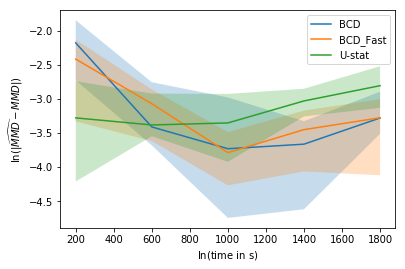

In [9]:
for i,solver in enumerate(solvers):
    mmd_vanilla_med = np.log(np.median(np.abs(mmd_vanilla[i]-d), axis=0))
    mmd_vanilla_err = log_error(np.abs(mmd_vanilla[i]-d), axis=0)
    name=solver.get('solver') if solver.get('MON') else 'U-stat'
    errorbar(num_of_samples,mmd_vanilla_med,mmd_vanilla_err,name)
plt.legend()
# Remark that contrary to the article, the plot is not with respect to time. 
# It is because it complicates things as we have to limit the process to one cpu in order to avoid the bias 
# due to the fact that python don't multithread everything.

In [10]:
mmd_outliers=compute_mmds('with_outliers',solvers,num_of_samples,M)

 Computation finished


In [11]:

for i,solver in enumerate(solvers) :
    mmd_outliers_med = np.log(np.median(np.abs(mmd_outliers[i]-d),axis=0))
    mmd_outliers_err = log_error(np.abs(mmd_outliers[i]-d), axis=0)
    name=solver.get('solver') if solver.get('MON') else 'U-stat'
    errorbar(num_of_samples,mmd_outliers_med,mmd_outliers_err,name)
plt.legend()

### Pareto plots, plots of $\widehat{MMD}_1-\widehat{MMD}_2$, where $\widehat{MMD}_1$ and $\widehat{MMD}_2$ are estimated MMD computed on two different samples of the same Pareto(3) distribution.

In [12]:
mmd_pareto1=compute_mmds('pareto',solvers,num_of_samples,M)
mmd_pareto2=compute_mmds('pareto',solvers,num_of_samples,M)

 Computation finished
 Computation finished


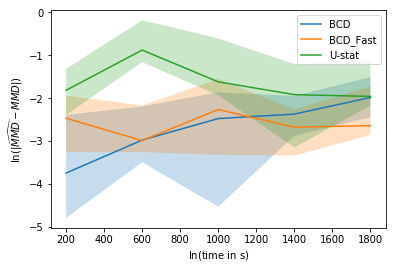

In [13]:

for i,solver in enumerate(solvers) :
    mmd_pareto_med = np.log(np.median(np.abs(mmd_pareto1[i]-mmd_pareto2[i]),axis=0))
    mmd_pareto_err = log_error(np.abs(mmd_pareto1[i]-mmd_pareto2[i]), axis=0)
    name=solver.get('solver') if solver.get('MON') else 'U-stat'
    errorbar(num_of_samples,mmd_pareto_med,mmd_pareto_err,name)
plt.legend()